# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Check Versions

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

2.1.2+cu121 True
1.2.2


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [2]:
# download and unzip
# !curl -o stanford_background.tar.gz http://dags.stanford.edu/data/iccv09Data.tar.gz
# !tar xf stanford_background.tar.gz

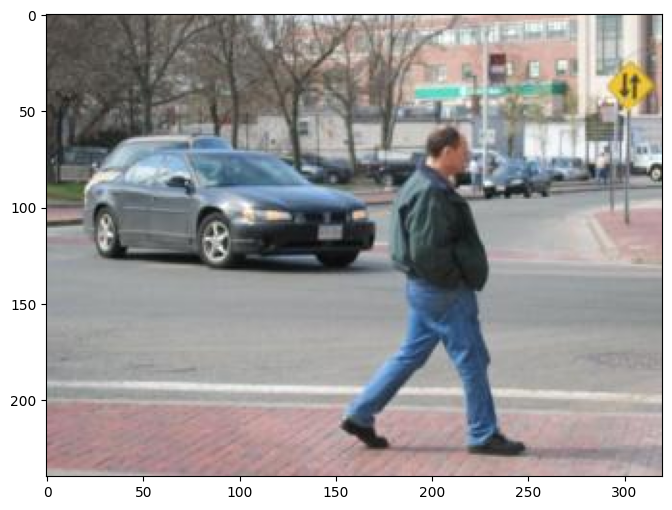

In [3]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [4]:
# define dataset root and directory for images and annotations
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and palette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

In [5]:
import os.path as osp
import numpy as np
from PIL import Image

# convert dataset annotation to semantic segmentation map
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
                                                         '.png')))

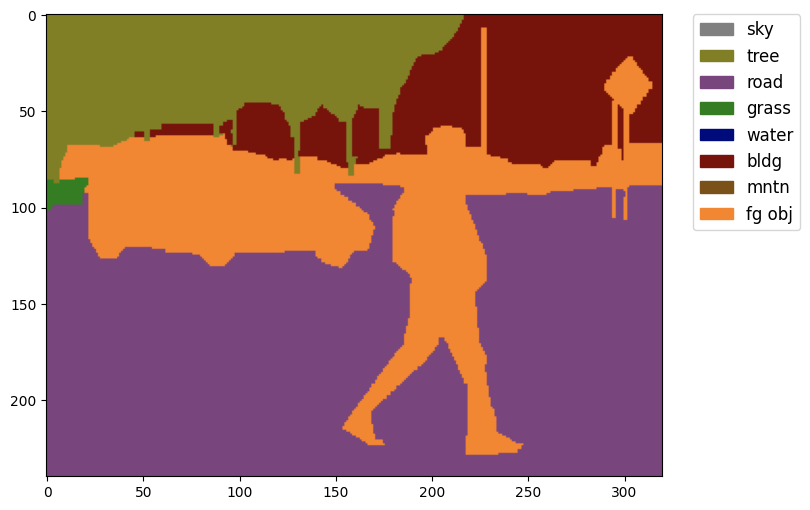

In [6]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [7]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [8]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [9]:
# Download config and checkpoint files
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest ./models

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in c:\Users\eraye\Desktop\Eray\ee563\04_openmmlab\mmsegmentation\models
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to c:\Users\eraye\Desktop\Eray\ee563\04_openmmlab\mmsegmentation\models


In [10]:
from mmengine import Config
cfg = Config.fromfile('models/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [11]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader

# Çoklu işlem (multiprocessing) hatasını önlemek için worker sayısını 0 yapıyoruz
cfg.train_dataloader.num_workers = 0
cfg.val_dataloader.num_workers = 0
cfg.test_dataloader.num_workers = 0

# num_workers=0 olduğunda persistent_workers=False olmak zorundadır
cfg.train_dataloader.persistent_workers = False
cfg.val_dataloader.persistent_workers = False
cfg.test_dataloader.persistent_workers = False


# Load the pretrained weights
cfg.load_from = 'models/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'iccv09Data'
dataset_type = 'StanfordBackgroundDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

### Train and Evaluation

In [12]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

02/14 02:07:10 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
    CUDA_HOME: None
    GCC: n/a
    PyTorch: 2.1.2+cu121
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=c

c:\Users\eraye\miniconda3\envs\openmmlab\lib\site-packages\mmseg\models\backbones\resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
c:\Users\eraye\miniconda3\envs\openmmlab\lib\site-packages\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
c:\Users\eraye\miniconda3\envs\openmmlab\lib\site-packages\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


02/14 02:07:13 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/14 02:07:13 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

c:\Users\eraye\miniconda3\envs\openmmlab\lib\site-packages\mmseg\engine\hooks\visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [13]:
# start training
runner.train()

02/14 02:07:21 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
02/14 02:07:21 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
02/14 02:07:21 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
02/14 02:07:21 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: models/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with sh

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

Inference with trained model

Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_200.pth


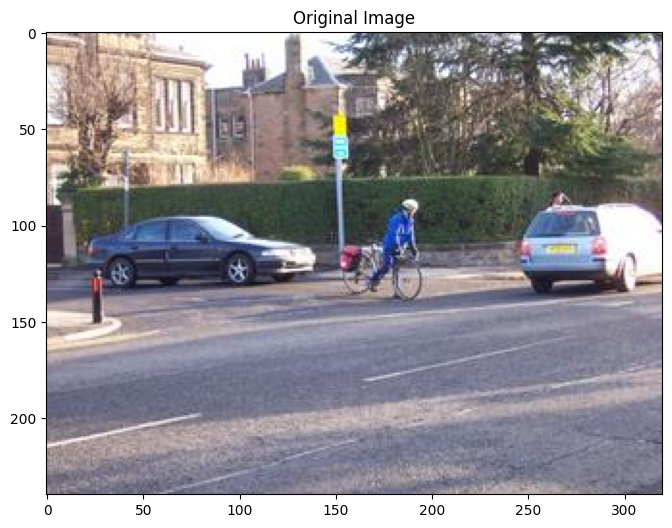

<Figure size 1400x600 with 0 Axes>

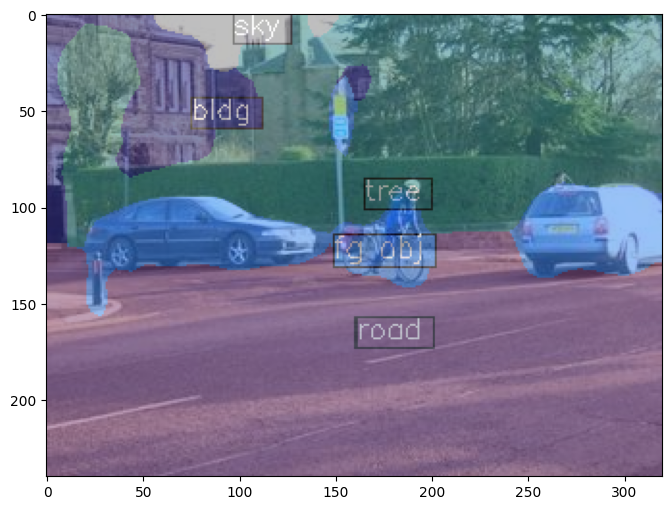

<Figure size 1400x600 with 0 Axes>

In [18]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('iccv09Data/images/9004199.jpg')

plt.figure(figsize=(8, 6))
# BGR'den RGB'ye çevirip gösteriyoruz
plt.imshow(mmcv.bgr2rgb(img))
plt.title('Original Image')
plt.show()

result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

plt.figure(figsize=(14, 6))


### Hata ve Çözüm Notu: Windows'ta Eğitimin Donması

**Sorun:** `runner.train()` komutu çalıştırıldığında eğitim başlamadan işlem donuyordu. Hata mesajı vermiyor, sadece bekliyordu.

**Neden:** Windows işletim sistemi, PyTorch'un veri yükleme (DataLoader) sırasında kullandığı çoklu işlem (multiprocessing) yöntemini Linux gibi desteklemiyor. Veriyi paralel yüklemeye çalışan alt süreçler (worker processes) ana süreçle iletişim kuramayarak kilitleniyordu (deadlock).

**Çözüm:** Veri yükleme işleminin paralel değil, tek bir ana süreçte yapılmasını sağladık.

**Uygulanan Kod:**
```python
# Veri yükleme işlemi için alt süreçler (worker) iptal edildi
cfg.train_dataloader.num_workers = 0
cfg.val_dataloader.num_workers = 0
cfg.test_dataloader.num_workers = 0

# Worker sayısı 0 olduğu için kalıcı worker özelliği de kapatıldı (Hata önleyici)
cfg.train_dataloader.persistent_workers = False
cfg.val_dataloader.persistent_workers = False
cfg.test_dataloader.persistent_workers = False
```

**Sonuç:** Veri yükleme işlemi ana sürece alındı, kilitlenme çözüldü ve eğitim başarıyla tamamlandı.